In [1]:
import os
import json

base_dir = os.getcwd()

results_dir = os.path.join(base_dir, '../../', 'benchmark', 'cache')

figures_dir = os.path.join(base_dir, 'figure')
os.makedirs(figures_dir, exist_ok=True)


In [2]:
all_data: list = []
for file_name in os.listdir(results_dir):
    if file_name.endswith('.log'):
        file_path = os.path.join(results_dir, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            print(f"Loaded file: {file_path}")
            all_data.append(data)

Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\dataset_analysis\../../benchmark\cache\lmms-lab-MME_test_-mnt-cfs-9n-das-admin-llm_models-llava-v1.6-vicuna-7b-hf.log
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\dataset_analysis\../../benchmark\cache\lmms-lab-POPE_test_-mnt-cfs-9n-das-admin-llm_models-llava-v1.6-vicuna-7b-hf.log
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\dataset_analysis\../../benchmark\cache\lmms-lab-TextCaps_test_-mnt-cfs-9n-das-admin-llm_models-llava-v1.6-vicuna-7b-hf.log
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\dataset_analysis\../../benchmark\cache\lmms-lab-textvqa_test_-mnt-cfs-9n-das-admin-llm_models-llava-v1.6-vicuna-7b-hf.log
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\dataset_analysis\../../benchmark\cache\lmms-lab-VizWiz-VQA_test_-mnt-cfs-9n-das-admin-llm_models-llava-v1.6-vicuna-7b-hf.log


In [3]:
import numpy as np
import pandas as pd

header = [
    'Dataset', 
    '# Request', 
    'Min Pixels', 
    'Max Pixels', 
    'Avg. Pixels', 
    'Min Input Tokens', 
    'Max Input Tokens', 
    'Avg. Input Tokens', 
    'Min Output Tokens', 
    'Max Output Tokens', 
    'Avg. Output Tokens', 
]
data = []
for dataset in all_data:
    all_n_pixels: list[int] = []
    all_n_input_tokens: list[int] = []
    all_n_output_tokens: list[int] = []
    for request in dataset['requests']:
        for image_size in request['images_size']:
            all_n_pixels.append(image_size[0] * image_size[1])
        all_n_input_tokens.append(request['n_input_tokens'])
        all_n_output_tokens.append(request['n_output_tokens'])
    data.append((
        dataset['dataset'], 
        len(dataset['requests']), 
        np.min(all_n_pixels),
        np.max(all_n_pixels),
        np.mean(all_n_pixels),
        np.min(all_n_input_tokens),
        np.max(all_n_input_tokens),
        np.mean(all_n_input_tokens),
        np.min(all_n_output_tokens),
        np.max(all_n_output_tokens),
        np.mean(all_n_output_tokens),
    ))
df = pd.DataFrame(data, columns=header)
display(df)

,Dataset,# Request,Min Pixels,Max Pixels,Avg. Pixels,Min Input Tokens,Max Input Tokens,Avg. Input Tokens,Min Output Tokens,Max Output Tokens,Avg. Output Tokens
0,lmms-lab/MME,2374,13020,33405360,1.881888e+06,1011,2974,2160.379528,2,230,14.483993
1,lmms-lab/POPE,9000,121500,409600,2.772434e+05,1477,2950,2270.157556,11,71,24.159222
2,lmms-lab/TextCaps,3289,276480,28934496,7.857419e+05,1779,2955,2339.352083,5,1024,23.504409
3,lmms-lab/textvqa,5734,276480,28934496,7.901421e+05,1769,2958,2334.912452,2,1024,43.379665
4,lmms-lab/VizWiz-VQA,8000,4914,5018112,1.684057e+06,1007,2954,2354.636125,2,1024,82.691375


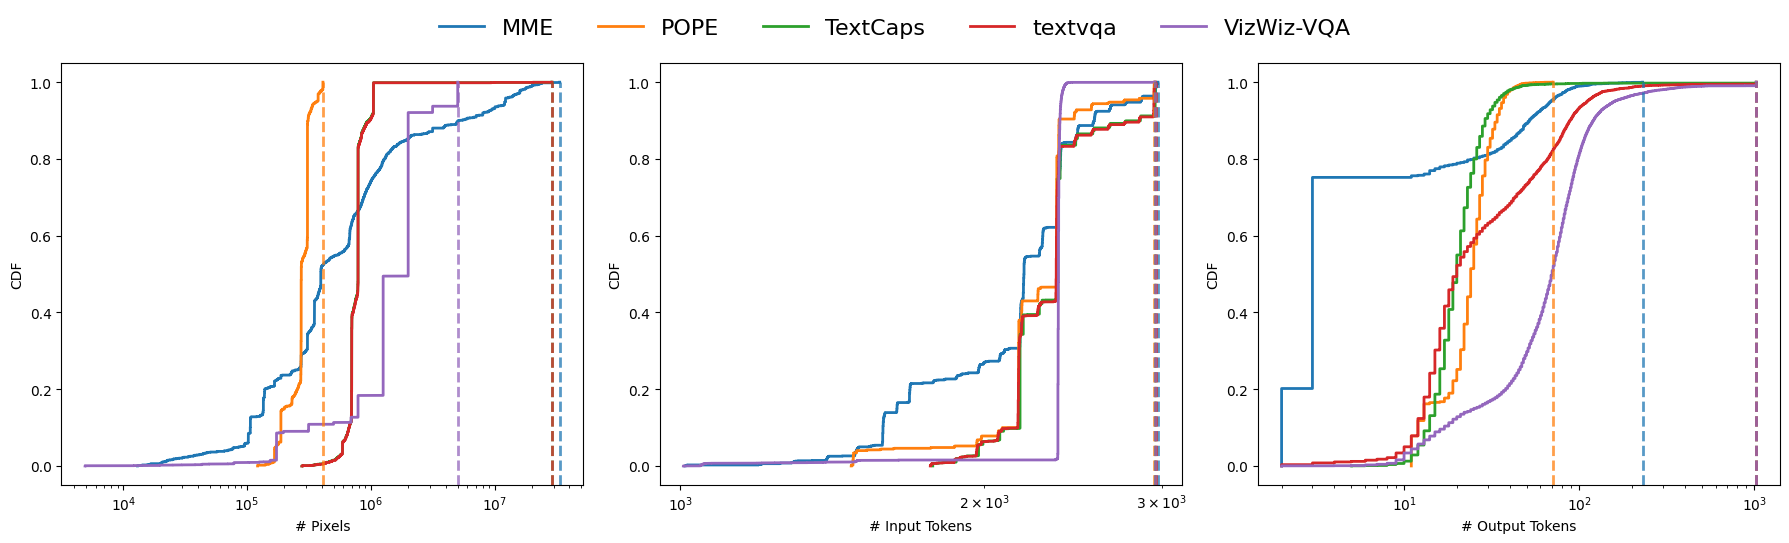

In [5]:
import matplotlib.pyplot as plt
def draw_workload_distribution_cdf():
    # plt.rcParams.update({"font.size": 22})
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for dataset in all_data:
        all_n_pixels: list[int] = []
        all_n_input_tokens: list[int] = []
        all_n_output_tokens: list[int] = []
        for request in dataset['requests']:
            for image_size in request['images_size']:
                all_n_pixels.append(image_size[0] * image_size[1])
            all_n_input_tokens.append(request['n_input_tokens'])
            all_n_output_tokens.append(request['n_output_tokens'])
        label = dataset['dataset'].split('/')[1]
        axes[0].ecdf(all_n_pixels, label=label, linewidth=2)
        axes[1].ecdf(all_n_input_tokens, label=label, linewidth=2)
        axes[2].ecdf(all_n_output_tokens, label=label, linewidth=2)

    # Draw vertical line at the end of the CDF
    for ax in axes:
        for line in list(ax.get_lines()):
            color = line.get_color()
            x_max = line.get_xdata()[-1]
            ax.plot([x_max, x_max], [-0.05, 1.0], color=color, linestyle="--", alpha=0.75, linewidth=2)

    axes[0].set_xlabel("# Pixels")
    axes[1].set_xlabel("# Input Tokens")
    axes[2].set_xlabel("# Output Tokens")

    for ax in axes:
        ax.set_xscale("log")
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel("CDF")

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.10), ncol=5, frameon=False, prop={"size": 16})
    fig.tight_layout()

    fig.savefig(os.path.join(figures_dir, "dataset_analysis.pdf"), bbox_inches="tight")
draw_workload_distribution_cdf()

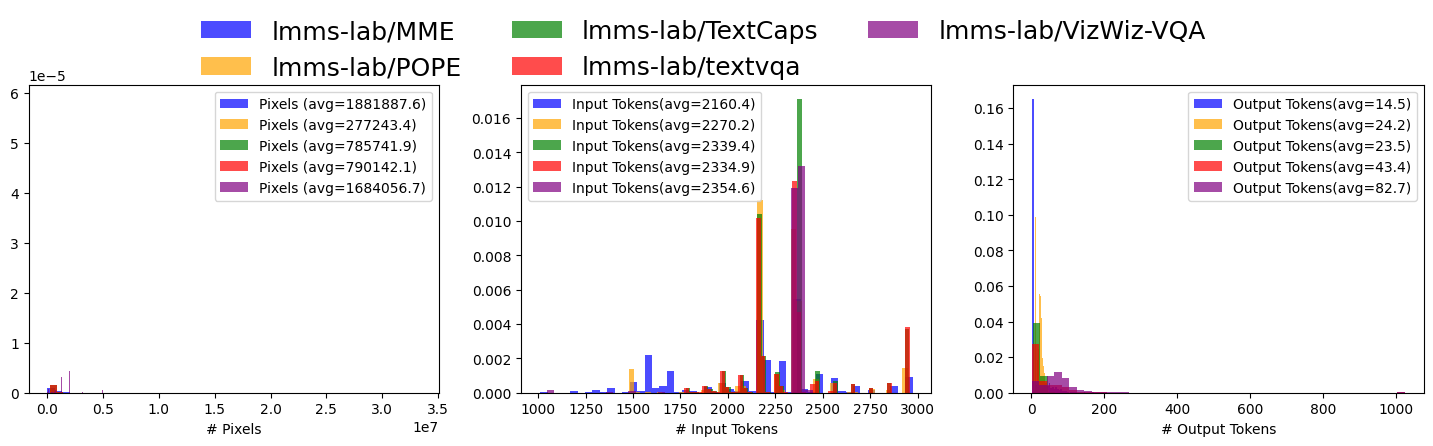

In [6]:
import numpy as np
import matplotlib.pyplot as plt

n_dataset = len(all_data)

n_rows = 1
n_cols = 3
figsize = (6 * n_cols, 4 * n_rows)
color_list: list[str] = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = np.atleast_2d(axes)

for i in range(n_dataset):
    color = color_list[i]
    dataset = all_data[i]
    all_n_pixels: list[int] = []
    all_n_input_tokens: list[int] = []
    all_n_output_tokens: list[int] = []
    for request in dataset['requests']:
        for image_size in request['images_size']:
            all_n_pixels.append(image_size[0] * image_size[1])
        all_n_input_tokens.append(request['n_input_tokens'])
        all_n_output_tokens.append(request['n_output_tokens'])
    axes[0][0].hist(all_n_pixels, bins=50, density=True, color=color, alpha=0.7, label=f"Pixels (avg={np.mean(all_n_pixels):.1f})")
    axes[0][1].hist(all_n_input_tokens, bins=50, density=True, color=color, alpha=0.7, label=f"Input Tokens(avg={np.mean(all_n_input_tokens):.1f})")
    axes[0][2].hist(all_n_output_tokens, bins=50, density=True, color=color, alpha=0.7, label=f"Output Tokens(avg={np.mean(all_n_output_tokens):.1f})")

for i in range(3):
    axes[0][i].legend()
axes[0][0].set_xlabel("# Pixels")
axes[0][1].set_xlabel("# Input Tokens")
axes[0][2].set_xlabel("# Output Tokens")
fig.legend(
    [dataset['dataset'] for dataset in all_data], 
    loc='upper center', ncol=3, fontsize=18, frameon=False, bbox_to_anchor=(0.5, 1.1))
    

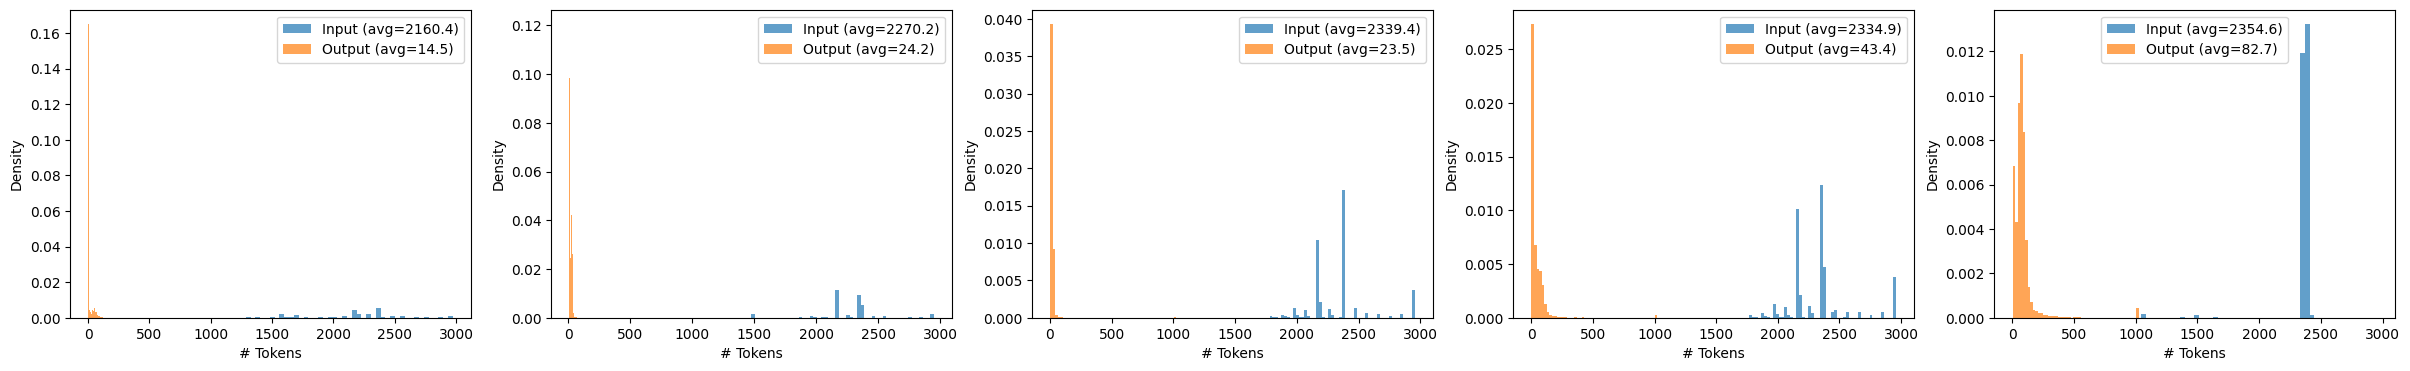

In [7]:
import numpy as np
import matplotlib.pyplot as plt

n_dataset = len(all_data)

n_rows = 1
n_cols = n_dataset
figsize = (6 * n_cols, 4 * n_rows)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
for i in range(n_cols):
    dataset = all_data[i]
    all_n_pixels: list[int] = []
    all_n_input_tokens: list[int] = []
    all_n_output_tokens: list[int] = []
    for request in dataset['requests']:
        for image_size in request['images_size']:
            all_n_pixels.append(image_size[0] * image_size[1])
        all_n_input_tokens.append(request['n_input_tokens'])
        all_n_output_tokens.append(request['n_output_tokens'])
        
    ax = axes[i]
    # ax.hist(all_n_pixels, bins=50, density=True, alpha=0.7, label=f"Pixels (avg={np.mean(all_n_pixels):.1f})")
    ax.hist(all_n_input_tokens, bins=50, density=True, alpha=0.7, label=f"Input (avg={np.mean(all_n_input_tokens):.1f})")
    ax.hist(all_n_output_tokens, bins=50, density=True, alpha=0.7, label=f"Output (avg={np.mean(all_n_output_tokens):.1f})")
    ax.set_xlabel("# Tokens")
    ax.set_ylabel("Density")
    # ax.text(7, -0.3, dataset['dataset'], ha='center', va='bottom', fontsize=18)
    ax.legend()